In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

# Sensor Distributions (CUDA accelerated)

While it is possible to construct new Gen distributions by combining already defined ones, this approach, while offering flexibility and ease of implementation, may come at the cost of performance. In order to address this potential drawback, Gen provides the capability to define custom Gen distributions by implementing the methods of the Distribution API.

We will write a CUDA accelerated custom Gen distribution based on a 2D version of the 3DP3-likelihood, so we can enhance the robot's ability to perceive its surroundings with even greater efficiency.

We also write a version that enables us to sample depth images and not point clouds....

The main functions we export are:
- `get_2d_mixture_components`
- `sensor_logpdf`
- `sensordist_2dp3`
- ...

## Setup and Usage
- You need to update your `LOAD_PATH` and add the paths to `MyUtils` and `MyCudaUtils`, before using this module!

In [1]:
using Markdown
# This is a fix for vscode, because it doesn't like 
# julia docstrings for whatever reason, and throws a `Katex` error.
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
push!(LOAD_PATH, "../../src");
include("../../src/pose.jl")
include("src/house_expo_data.jl");
include("../src/cuda_raycaster_line_map_b.jl")

[ Info: Precompiling MyUtils [top-level]
[ Info: Precompiling Geometry [top-level]


Loading data from `../data/task_inputs/test_env_1.json`, and
populating Main namespace with variables:

_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64


In [3]:
push!(LOAD_PATH, "../../../src");

In [14]:
#nbx --fname=../../../src/SensorDistributions.jl --jl_module=SensorDistributions

using Colors, Plots, Images;
col = palette(:default);
using BenchmarkTools
using CUDA
using Gen
# Make sure to update `LOAD_PATH` accordingly, 
# to point to the `src` folder of `MyUtils`
using MyUtils 
const diagnormal = broadcasted_normal
using Test


In [6]:
typeof(DeviceArray(rand(2,10))),
_cuda[]

(CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}, true)

We start off with a couple of functions that we need broadcastable versions of: 
 - `polar_inv`, a CUDA version of the invererse of polar coordinate transformation.
 - `gaussian_logpdf`, a broadcastable Gaussian logpdf.
 - `logsumexp_slice`, a version of `logsumexp` that can be applied along a dimension.

In [7]:
#nbx
MyUtils.polar_inv(z::CuArray, a::CuArray) = z.* cat(cos.(a), sin.(a), dims=ndims(a)+1);

Normal Distribution: $N(x; \mu, \sigma) = \frac {1}{\sigma {\sqrt {2\pi }}} e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}$

In [8]:
#nbx
"""
```julia
    log_p = gaussian_logpdf(x, mu, sig)
````
Broadcastable Gaussian logpdf -- benchmarked in `33 - CUDA Accelerated Gen Distributions`.
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sig) .- log(sqrt(2π)) .- 1/2 * d
    return log_p
end;

Just a quick reality check that we did not mess anything up in the definition above.

In [9]:
@testset "Gaussian reality check" begin 
for i=1:100
    x   = rand()
    mu  = rand()
    sig = rand()
    
    @test isapprox(logpdf(normal,  x, mu, sig), 
                   gaussian_logpdf(x, mu, sig))
    @test gaussian_logpdf(x, Inf, 1.0)   == -Inf
    @test gaussian_logpdf(Inf, 0.0, 1.0) == -Inf
end 
end;

Test Summary:          | Pass  Total  Time
Gaussian reality check |  300    300  0.3s


CDF of Normal Distribution: $\Phi(x; \mu, \sigma) =  {\frac {1}{2}}\left[1+\operatorname {erf} \left({\frac {x-\mu }{\sigma {\sqrt {2}}}}\right)\right]$

In [10]:
#nbx
using SpecialFunctions: erf
"""
```julia
    log_c = gaussian_logcdf(x, mu, sig)
````
Broadcastable Gaussian logcdf
"""
function gaussian_logcdf(x, mu, sig)
    d = (x .- mu)./(sig.*sqrt(2))
    log_c = - log(2) .+ log.(1 .+ erf.(d))
    return log_c
end;

function gaussian_cdf(x, mu, sig)
    d = (x .- mu)./(sig.*sqrt(2))
    return (1 .+ erf.(d))./2
end;

In [11]:
using Distributions: cdf, Normal
x = rand(Normal(0,100))
mu = 0.0
sig = 1.0

@testset "Gaussian CDF reality check" begin 
    for i=1:100
        x = rand(Normal(0,100))
        mu  = rand(Normal(0,100))
        sig = 100*rand()
        @test isapprox(
            gaussian_cdf(x, mu, sig), 
            cdf(Normal(mu, sig), x), atol=1e-9)
    end 
end;


Test Summary:              | Pass  Total  Time
Gaussian CDF reality check |  100    100  0.0s


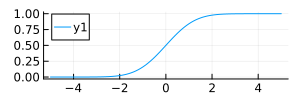

In [15]:
xs = -5:0.1:5
mu  = 0.0
sig = 1.0

# -------------------
plot(xs, exp.(gaussian_logcdf(xs, mu, sig)), size=(300,100))


In [16]:
#nbx
"""
```julia
  logsumexp_slice(x; dims)
```
Applies `logsumexp` along specified dimensions.


Benchmarks
```julia 
x: (2000, 2000)
dims: 2
with `check_inf`
  CPU  >>  49.887 ms (26 allocations: 30.57 MiB)
  CUDA >> 355.932 μs (367 allocations: 19.55 KiB)

without `check_inf`
  CPU  >>  54.482 ms (20 allocations: 30.56 MiB)
  CUDA >>  69.461 μs (142 allocations: 8.06 KiB)
```
"""
function logsumexp_slice(x::Union{CuArray, Array}; dims, check_inf=true)
    c = maximum(x, dims=dims)
    y = c .+ log.(sum(exp.(x .- c), dims=dims))
    
    # Note that if c is -Inf, then y will be NaN.
    if check_inf
        y[c .== -Inf] .= - Inf
    end
    return y
end;

In [17]:
logsumexp([Inf]), 
logsumexp([Inf,1.]),
logsumexp([Inf,-Inf]),
logsumexp([-Inf]), 
logsumexp([-Inf,-Inf]),
logsumexp([-Inf, 1.0])

(NaN, NaN, NaN, -Inf, -Inf, 1.0)

In [18]:
# Todo: make sure we tested all the edge cases 
#       we need (Inf's, NaN's...)
@testset "Logsumexp reality check" begin 
    for _=1:20
        x = rand(10,5)
        @test isapprox(
            logsumexp_slice(x, dims=2),
            log.(sum(exp.(x), dims=2)))
    end
    @test isnan.(logsumexp_slice([Inf; 1.0], dims=1))  == [true]
    @test logsumexp_slice([-Inf; 1.0], dims=1) == [1.0]
    @test logsumexp_slice([-Inf;-Inf], dims=1) == [-Inf]
end;

Test Summary:           | Pass  Total  Time
Logsumexp reality check |   23     23  0.6s


In [19]:
x  = rand(2000, 2000)

function bench_logsumexp(x, dims, check_inf)
    logsumexp_slice(x; dims=dims, check_inf=check_inf)
end

println("x: $(size(x))")
@btime bench_logsumexp($x , 2, true)  samples=3 evals=3;
@btime bench_logsumexp($x , 2, false) samples=3 evals=3;
if _cuda[]
    x_ = CuArray(x);
    @btime bench_logsumexp($x_, 2, true)  samples=3 evals=3;
    @btime bench_logsumexp($x_, 2, false) samples=3 evals=3;
end;

x: (2000, 2000)


  42.526 ms (26 allocations: 30.57 MiB)


  42.537 ms (20 allocations: 30.56 MiB)


  429.607 μs (367 allocations: 19.55 KiB)


  65.695 μs (142 allocations: 8.06 KiB)


## Sliding windows

**Todo:** 
- Add tests
- Check behaviour at the edges when NOT wrapping around

### CPU

In [20]:
slviews(z,w,s) = ((@view z[i:i+w-1]) for i in 1:s:length(z)-w+1)

function bench_it(n,w,s)
    stack(collect(slviews(1:n,4,1)))
end

@btime bench_it(500,10,1)  samples=3 evals=3;

  19.002 μs (3 allocations: 31.56 KiB)


In [21]:
using IterTools: partition

function bench_it(n,w,s)
    x = partition(1:n, w, s)
    stack(collect.(x))
end

@btime bench_it(500,10,1)  samples=3 evals=3;

  410.318 μs (2466 allocations: 384.28 KiB)


In [22]:
#nbx
import Compat
using ImageFiltering: BorderArray, Pad, Fill 

function slw_cpu(x, w; wrap=false, fill=false, fill_val=Inf)
    if wrap
        y = BorderArray(x, Pad(:circular, (0,w)));
    else
        if fill
            y = BorderArray(x, Fill(fill_val, (0,w)))
        else
            y = BorderArray(x,  Pad((0,w)))
        end
    end
    I = ((@view y[j, i-w:i+w]) for j=1:size(x,1), i in 1:size(x,2))
    y = Compat.stack(I)
    return permutedims(y, (2,3,1))  
end;


In [23]:
k = 500
n = 500
w = 20

x = rand(k,n)
y = slw_cpu(x,w)

println(size(y))

@btime slw_cpu(x,w)  samples=3 evals=3;

(500, 500, 41)


  243.756 ms (500012 allocations: 207.90 MiB)


### CUDA

In [24]:
#nbx 
# Todo: handle wrap around and padding smarter?
"""
```julia
    slw_kernel!(x, y, w::Int, wrap::Bool, fill::Bool, fill_val::Float64)
```
CUDA kernel to compute sliding windows.
Takes CuArrays of shape `(k,n)` and `(k,n,2w+1)`...
"""
function slw_kernel!(x, y, w::Int, wrap::Bool, fill::Bool, fill_val::Float64)
    
    m = 2*w + 1
    n = size(x,2)

    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform mixture index in `1:m` 
        # to offsets in `-w:w`
        offset = j_mix-1-w
        
        j = j_obs + offset
        if wrap
            # Wrap around
            j = mod(j - 1 , n) + 1
            val = x[j_pose, j]
        else
            if 1 <= j <= n
                val = x[j_pose, j]
            else
                if fill
                    # Fill with fill value
                    val = fill_val
                else 
                    # Fill with the edge values
                    j = max(min(j,n),1)
                    val = x[j_pose, j]
                end
            end
        end
        
        # Fill entries of `y`
        @inbounds y[j_pose, j_obs, j_mix] = val
    end
    return
end

"""
```julia
    y_ = slw_cu(x_::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
```
CUDA-accelerated function computing sliding windows. 
Takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    # `cuda_grid` defined in reaycaster file, I also put it in utils
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, y, w, wrap, fill, fill_val)
    end
    
    return y
end;
export slw_cu

In [25]:
@testset "Sliding windows GPU vs CPU reality check" begin 
    for i=1:100
        x  = rand(10,50)
        x_ = CuArray(x)
        w  = rand(1:20)
        
        args = (wrap=false, fill=false)
        y_ = slw_cu(x_, w; args...)
        y  = slw_cpu(x, w; args...)
        @test isapprox(Array(y_), y)

        args = (wrap=true,)
        y_ = slw_cu(x_, w; args...)
        y  = slw_cpu(x, w; args...)
        @test isapprox(Array(y_), y)

        args = (fill=true, fill_val=Inf)
        y_ = slw_cu(x_, w; args...)
        y  = slw_cpu(x, w; args...)
        @test isapprox(Array(y_), y)
    end 
end;

Test Summary:                            | Pass  Total  Time
Sliding windows GPU vs CPU reality check |  300    300  2.7s


In [26]:
k = 500
n = 500
w = 20

x  = stack(fill(collect(1.0:n), k))
@time x_ = CuArray(x)

y_ = slw_cu(x_, w, blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
y  = Array(y_);
y[1,:,:]

@btime slw_cpu($x, w, wrap=false, fill=false) samples=3 evals=3;
@btime slw_cu($x_, w, wrap=false, fill=false) samples=3 evals=3;

  0.000281 seconds (4 allocations: 160 bytes)


  232.702 ms (500012 allocations: 207.90 MiB)


  841.861 μs (43 allocations: 2.60 KiB)


### Combined

In [27]:
#nbx
"""
    y_ = slw(x_, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)

Function computing sliding windows, on the GPU.
Takes a CuArray of shape `(k,n)` and returns an CuArray
of shape `(k,n,m)`, where `m = 2w+1`...
"""
function slw(x_::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    y_ = slw_cu(x_, w; blockdims=blockdims, wrap=wrap, fill=fill, fill_val=fill_val)
    return y_
end;

In [28]:
#nbx
"""
    y = slw(x, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)

Function computing sliding windows, either on the CPU or GPU.
Takes an Array of shape `(k,n)` and returns an Array
of shape `(k,n,m)`, where `m = 2w+1`...
"""
function slw(x::Array, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    # Todo: Is that a good pattern??
    if _cuda[]
        x_ = CuArray(x)
        y_ = slw_cu(x_, w; blockdims=blockdims, wrap=wrap, fill=fill, fill_val=fill_val)
        return Array(y_)
    else
        return slw_cpu(x, w;  wrap=wrap, fill=fill, fill_val=fill_val)
    end
end;
export slw

## 2D Sensor Distribution (for point clouds)

### Mixture components

In [29]:
#nbx
# DEPRECIATED
"""
    ỹ_::CuArray = get_ys_tilde_cu(zs_::CuArray, w::Int)    

DEPRECIATED, use `get_2d_mixture_components` instead. 
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int; wrap=false, fill=false, fill_val=0.0)   

    zs_tilde_ = slw_cu(zs_, w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_ = slw_cu(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap)
    ys_tilde_ = polar_inv(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [30]:
#nbx
# Same as above but want to switch 
# to different name going forward
"""
```julia
    ỹ_::CuArray = get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 2d mixture components for the "2dp3" likelihood from a family 
depth scans `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z_`:    Range measurements `(k,n)`
 - `a_`:    Angles of measuremnts `(n,)`
 - `w`:     Filter window size

Returns:
 - `ỹ_`: CuArray of shape `(k, n, m, 2)`, where `m=2w+1`
"""
function get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                   wrap=false, fill=false, fill_val_z=Inf, fill_val_a=0.0)
    
    a_ = reshape(a_,1,:)
    
    z̃_ = slw_cu(z_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
    ã_ = slw_cu(a_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
    ỹ_ = polar_inv(z̃_, ã_)
    
    # Handle Inf's and NaN
    # Todo: Where were the NaNs coming from again? They're coming from Inf * 0;
    #       Could avoid that by choosing a fill value a such that cos(a) and sin(a) are non-zero, 
    #       or use a max z value < Inf.
    ỹ_[isnan.(ỹ_)] .= Inf

    return ỹ_
end;

In [31]:
#nbx
"""
```julia
    ỹ::Array = get_2d_mixture_components(z::Array, a::Array, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 2d mixture components for the "2dp3" likelihood from a family 
depth scans `z` along angles `a`, and with a filter radius of `w`.

Arguments:
 - `z`:    Range measurements `(k,n)`
 - `a`:    Angles of measuremnts `(n,)`
 - `w`:    Filter window size

Returns:
 - `ỹ`: Array of shape `(k, n, m, 2)`, where `m=2w+1`
"""
function get_2d_mixture_components(z::Array, a::Array, w::Int; 
                                   wrap=false, fill=false, 
                                   fill_val_z=Inf, fill_val_a=0.0)
    
    # Todo: Is that a good pattern??
    if _cuda[]
        z_ = CuArray(z)
        a_ = CuArray(a)
        ỹ_ = get_2d_mixture_components(z_, a_, w; 
                                        wrap=wrap, fill=fill, 
                                        fill_val_z=fill_val_z, fill_val_a=fill_val_a)
        return Array(ỹ_)
    else
        a = reshape(a,1,:)
        z̃ = slw_cpu(z, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
        ã = slw_cpu(a, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
        ỹ = polar_inv(z̃, ã)
    
        # Handle Inf's and NaN
        # Todo: Where were the NaNs coming from again? They're coming from Inf * 0;
        #       Could avoid that by choosing a fill value a such that cos(a) and sin(a) are non-zero, 
        #       or use a max z value < Inf.
        ỹ[isnan.(ỹ)] .= Inf

        return ỹ
    end
end;
export get_2d_mixture_components

### 2dp3 Likelihood 

In [32]:
#nbx
"""
```julia
    log_ps, ptw = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```
Evaluates an observation `x` under the 2dp3 likelihood with <br/>
a family of mixture components `ỹ` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
 - `x`: Observation point cloud `(n,2)`
 - `ỹ`: Family of mixture components `(k,n,m,2)`
 - `sig`: Std deviation of Gaussian mixture components; either a scalar or an array of shape `(1,1,1,1, ...)` (should be broadcastable with `outlier` and the rest)
 - `outlier`: Outlier probability; either a scalar or an array of shape `(1,1,1,1, ...)` (should be broadcastable with `sig` and the rest)

Returns:
 - `log_ps`: Log-probs `(k,)` ,or `(k, ...)` in case of non-scalar `sig` and `outlier`
 - `ptw`:    Pointwise log-probs for each observation point `(k,n)`  ,or `(k,n, ...)` in case of non-scalar `sig` and `outlier`
"""
function sensor_logpdf(x, ỹ, sig, outlier, outlier_vol; return_pointwise=false, return_outliermap=false) 
    @assert size(x,1) == size(ỹ,2)

    k = size(ỹ,1)
    n = size(ỹ,2)
    m = size(ỹ,3)
    x = reshape(x, 1, n, 1, 2)
    
    # Inlier probability (Gaussian mixtures).
    #   Compute 1D Gaussians (k,n,m,2)
    #   Convert to 2D gausians (k,n,m,1)
    #   Convert to mixture `gm` of m 2D gausians (k,n,1,1)
    log_p = gaussian_logpdf(x, ỹ, sig)
    log_p = sum(log_p, dims=4)
    log_p = logsumexp_slice(log_p .- log(m), dims=3)

    # Outlier probability 
    # and outlier map
    # Todo: Find a better outlier prob? 
    #       Change outlier_vol = 2π*zmax^2?
    log_out = - log(outlier_vol)
    outliermap = nothing
    if return_outliermap
        outliermap = log.(1. .- outlier) .+ log_p .< log.(outlier) .+ log_out
    end

    # Convert to mixture of `gm` and `outlier` (k,n,1,1)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier.*exp.(log_out))
    
    # If we don't need pointwise logprobs
    # we can save us the time and space to copy
    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=(3,4))
    end

    # Convert to product of mixtures (k,1,1,1)
    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=(2,3,4))

    return log_p, pointwise, outliermap
end
# Todo: Make sure we handle Inf's in y correctly --
#       that might come from sliding window fills? 

export sensor_logpdf

# Backwards compatibility -- 
# Same as `sensor_logpdf` above
"""
DEPRECIATED, use `sensor_logpdf` instead.
"""
function sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol; return_pointwise=false)
    return sensor_logpdf(x, y, sig, outlier, outlier_vol; return_pointwise=return_pointwise)
end;

In [33]:
k = 2
n = 3
m = 3

x   = rand(n,2)
ys  = rand(k,n,m,2)

# Insert some Inf's, that might come 
# from sliding window fills. 
ys[1,:,:,:] .= Inf

x_  = DeviceArray(x)
ys_ = DeviceArray(ys)

sig     = 0.1
outlier = 0.1
outlier_vol = 100.0


log_ps , ptw , = sensor_logpdf(x , ys , sig, outlier, outlier_vol; return_pointwise=true)
log_ps_, ptw_, = sensor_logpdf(x_, ys_, sig, outlier, outlier_vol; return_pointwise=true)

println(size(log_ps))


@assert isapprox(log_ps, Array(log_ps_))
@assert isapprox(minimum(ptw[1,:]), log(outlier/outlier_vol))


(2,)


In [34]:
sig     = reshape(range(0.5,0.05, 11), 1,1,1,1, :,1)
outlier = reshape(range(0.1,1e-6, 12), 1,1,1,1, 1,:)
outlier_vol = 100.0

sig_     =  DeviceArray(sig)
outlier_ = DeviceArray(outlier)

log_ps_, ptw_, = sensor_logpdf(x_, ys_, sig_, outlier_, outlier_vol; return_pointwise=true)

size(log_ps_), size(ptw_)

((2, 11, 12), (2, 3, 11, 12))

### Distribution

In [35]:
#nbx
struct SensorDistribution2DP3 <: Distribution{Vector{Vector{Float64}}} 
end

"""
```julia
    x = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)::Vector{Vector{Float64}}
```
Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and 
samples a vector `x` of 2d points.

Arguments:
 - `ỹ_`: 2d-mixture components `(n,m,2)`
 - ...
Returns:
- `x`: Observation vector of 2d points.
"""
const sensordist_2dp3 = SensorDistribution2DP3()

function Gen.logpdf(::SensorDistribution2DP3, x, ỹ_::CuArray, sig, outlier, outlier_vol)
    n = size(ỹ_, 1)
    m = size(ỹ_, 2)
    
    x_ = CuArray(stack(x))
    ỹ_ = reshape(ỹ_, 1, n, m, 2) 
    
    log_p, = sensor_logpdf(x_, ỹ_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.logpdf(::SensorDistribution2DP3, x, ỹ::Array, sig, outlier, outlier_vol)
    n = size(ỹ, 1)
    m = size(ỹ, 2)

    x = stack(x)
    ỹ = reshape(ỹ, 1, n, m, 2) 
    
    log_p, = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol) # Array of length 1
    return log_p[1]
end

# Todo: Speed up sampling, the Gen plug-and-play version is 
#       faster when sampling. Slow at evaluation.
function Gen.random(::SensorDistribution2DP3, ỹ_::CuArray, sig, outlier, outlier_vol)
    n = size(ỹ_,1)
    m = size(ỹ_,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(ỹ_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end

function Gen.random(::SensorDistribution2DP3, ỹ::Array, sig, outlier, outlier_vol)
    n = size(ỹ,1)
    m = size(ỹ,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = ỹ[i,j,:]
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end;

(D::SensorDistribution2DP3)(args...) = Gen.random(D, args...)

# TODO: Add output and arg grads.
Gen.has_output_grad(::SensorDistribution2DP3)    = false
Gen.has_argument_grads(::SensorDistribution2DP3) = (false, false);

export sensordist_2dp3

In [36]:
n = 500
m = 41

ys  = rand(n,m,2)
ys_ = DeviceArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0
args = (ys_, sig, outlier, outlier_vol)
x = sensordist_2dp3(args...)
logpdf(sensordist_2dp3, x, args...)

println("y_: $(size(ys))")
@btime logpdf(sensordist_2dp3, x, args...) samples=3 evals=3;

y_: (500, 41, 2)


  443.671 μs (598 allocations: 56.33 KiB)


Benchmark (GPU)
```julia
y_: (500, 41, 2)
  443.054 μs (598 allocations: 56.33 KiB)
```

In [34]:
@doc cast

```julia
    zs = cast(ps, segs; fov=2π, num_a::Int=361, zmax::Float64=Inf)
```

Computes depth measurements `zs` with respect to a family of stacked poses `ps` and family of stacked line segments `segs` along a fixed number `num_a` of equidistantly spaced angles in the field of view `fov`.

If a CUDA supported GPU is available we run a GPU accelerated version.

Arguments:

  * `ps`: Stacked poses `(k, 3)`
  * `segs`: Stacked line segments `(n, 4)`
  * ...

Returns:

  * `zs`: Depth measurements in the field of view `(k, num_a)`


In [35]:
_fov = π
_num_a = 100
_zs = cast(stack(Vector.(_ps)), stack(Vector.([_segs;_boxes])); fov=_fov, num_a=_num_a);
_zs = unstack(_zs)

_zs_appr = cast(stack(Vector.(_ps)), stack(Vector.(_segs)); fov=_fov, num_a=_num_a);
_zs_appr =unstack(_zs_appr)

_as = create_angles(_fov, _num_a);
_ys = polar_inv.(_zs, [_as]);
_ys_appr = polar_inv.(_zs_appr, [_as]);

0


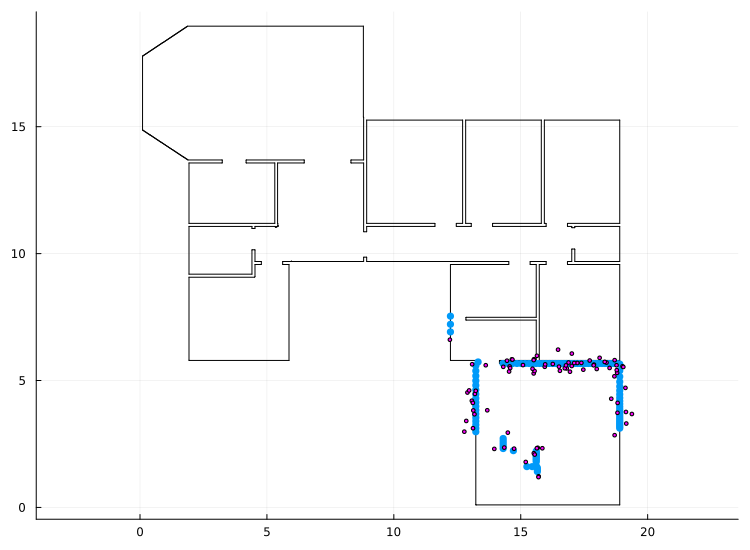

In [36]:
t = 2
zs_ = DeviceArray(stack(_zs[[t]]))
as_ = DeviceArray(_as);

w           = 20
sig         = 0.2
outlier     = 0.1
outlier_vol = 100.


ỹ_ = get_2d_mixture_components(zs_, as_, w; wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a = 0.0);

println(sum(isnan.(ỹ_)))

xs = [sensordist_2dp3(ỹ_[1,:,:,:], sig, outlier, outlier_vol) for i=1:1]
xs = reduce(vcat, xs)

# ----------------
mypl = plot(size=(750,550), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!(_ys[t].*_ps[t], markerstrokewidth=0, c=col[1], label="Reference (Map)")
args = (
    markersize=2, 
    alpha=1., 
    markerstrokewidth=1,
    c=:magenta
)
scatter!(xs.*_ps[t]; args..., label="Samples")
display(mypl)

## 1D Sensor Distribution


### 1D Mixture

In [37]:
#nbx
"""
```julia
    ỹ_, d̃_ = get_1d_mixture_components(z_, a_, w, sig; 
                                       wrap=false, fill=true, 
                                       fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 1d projections of mixture components onto the rays and 
their distances to the rays for the "2dp3" likelihood from 
depth measurements `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z_`: Range measurements `(k,n)`
 - `a_`: Angles of measuremnts `(n,)`
 - `w``: Filter window radius

Returns:
 - `ỹ_`: Projections onto ray `(k, n, m)`, where `m=2w+1`
 - `d̃_`: Distances to ray `(k, n, m)`, where `m=2w+1`
"""
function get_1d_mixture_components(z_::CuArray, a_::CuArray, w; 
                                   wrap=false, fill=false, 
                                   fill_val_z=Inf, fill_val_a=0.0)
                                   
    a_ = reshape(a_,1,:)
    z̃_ = slw_cu(z_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
    ã_ = slw_cu(a_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
    
    # We compute the projection `ỹ` of the 2d mixtures onto 
    # the ray through each pixel and their distance `d̃` to the rays.
    #
    # Note that the embedded point is of the form `[z*cos(a), z*cos(a)]` and 
    # the projections are given by the dot products with the x- and y-axis.
    ã_ = ã_ .- a_
    ỹ_ = z̃_ .* cos.(ã_)
    d̃_ = z̃_ .* sin.(ã_)
    
    # Handle NaN coming from Inf * 0.0
    if fill && fill_val_z == Inf
        d̃_[isnan.(d̃_)] .= Inf
        ỹ_[isnan.(ỹ_)] .= Inf
    end
    
    return ỹ_, d̃_
end;

In [38]:
#nbx
"""
```julia
    ỹ, d̃ = get_1d_mixture_components(z, a, w, sig; 
                                       wrap=false, fill=true, 
                                       fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 1d projections of mixture components onto the rays and 
their distances to the rays for the "2dp3" likelihood from 
depth measurements `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z`: Range measurements `(k,n)`
 - `a`: Angles of measuremnts `(n,)`
 - `w``: Filter window radius

Returns:
 - `ỹ`: Projections onto ray `(k, n, m)`, where `m=2w+1`
 - `d̃`: Distances to ray `(k, n, m)`, where `m=2w+1`
"""
function get_1d_mixture_components(z, a, w; 
                                   wrap=false, fill=false, 
                                   fill_val_z=Inf, fill_val_a=0.0)
                                   
    if _cuda[]
        z_ = CuArray(z)
        a_ = CuArray(a)
        ỹ_, d̃_ = get_1d_mixture_components(z_, a_, w; 
                                            wrap=wrap, fill=fill, 
                                            fill_val_z=fill_val_z, fill_val_a=fill_val_a)
        return Array(ỹ_), Array(d̃_)
    else
        a = reshape(a,1,:)
        z̃ = slw_cpu(z, w; wrap=wrap, fill=fill, fill_val=fill_val_z)
        ã = slw_cpu(a, w; wrap=wrap, fill=fill, fill_val=fill_val_a)

        # We compute the projection `ỹ` of the 2d mixtures onto 
        # the ray through each pixel and their distance `d̃` to the rays.
        #
        # Note that the embedded point is of the form `[z*cos(a), z*cos(a)]` and 
        # the projections are given by the dot products with the x- and y-axis.
        ã = π/2 .- ã .+ a
        d̃ = z̃ .* cos.(ã)
        ỹ = z̃ .* sin.(ã)
        
        # Handle NaN coming from Inf * 0.0
        if fill && fill_val_z == Inf
            d̃[isnan.(d̃)] .= Inf
            ỹ[isnan.(ỹ)] .= Inf
        end
        
        return ỹ, d̃
    end
end;

export get_1d_mixture_components;

In [39]:
t   = 2
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 10
sig     = 0.1
outlier = 0.1
zmax    = 100.

ỹ_, w̃_ = get_1d_mixture_components(zs_, as_, w,
                                   wrap=false, fill=false);

println(size(ỹ_))
println(size(w̃_))
println(sum(isnan.(ỹ_)))

UndefVarError: UndefVarError: _zs not defined

In [40]:
t   = 2
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 10
sig     = [range(0.1,0.5,10)...]
outlier = 0.1
zmax    = 100.

sig_ = CuArray(sig)

ỹ_, w̃_ = get_1d_mixture_components(zs_, as_, w,
                                 wrap=false, fill=false);

println(size(ỹ_))
println(size(w̃_))



UndefVarError: UndefVarError: _zs not defined

### 1d Likelihood

In [41]:
#nbx
"""
```julia
    log_ps, ptw, outl = depthdist_logpdf(z, ỹ, d̃, sig::Union{Float64,AbstractArray}, outlier::Union{Float64,AbstractArray}, zmax, noise_anchor=1.0; 
                                         scale_noise=false, return_pointwise=false, return_outliermap=false)
```
Evaluates an depth measurement `z` under the 2dp3 likelihood with respect to<br/>
a family of 1d mixture components `ỹ` and their distances `d̃` and <br/>
parameters `sig`, `outlier`, and `zmax`...

Arguments:
    - `z`:   Depth measurements `(n,)`
    - `ỹ`:   Family of 1d-mixture components `(k,n,m)`
    - `d̃`:   Family of 1d-mixture distances `(k,n,m)`
    - `sig`: Standard deviation of the mixture components; either a scalar, or 
             an array that is broadcastable with the rest of the args, e.g. `(1,1,1, ...)`
    - `outlier`: Outlier probability; either a scalar, or 
                 an array that is broadcastable with the rest of the args, e.g. `(1,1,1, ...)`
    - `zmax`:         Maximum depth value
    - `scale_noise`:  If true, the noise is scaled by the depth value
    - `noise_anchor`: The depth value at which the noise is scaled to `sig`

Returns:
    - `log_ps`: Log-probs `(k,)` (or `(k, ...)` if sig or outlier are arrays)
    - `ptw`:    Pointwise log-probs for each observation point `(k,n)` (or `(k,n, ...)` if sig or outlier are arrays)
    - `outl`:   Pointwise outlier map for each observation point `(k,n)` (or `(k,n, ...)` if sig or outlier are arrays)
"""
function depthdist_logpdf(z, ỹ, d̃, sig::Union{Float64,AbstractArray}, outlier::Union{Float64,AbstractArray}, zmax, noise_anchor=1.0; 
                          scale_noise=false, return_pointwise=false, return_outliermap=false)
    
    # Truncate depth and make compatible with ỹ, d̃
    # Todo: Should we actually clamp ourselves?
    z = clamp.(z, 0.0, zmax)
    z = reshape(z, 1, length(z), 1)

    # For the hierarchical Bayes verson
    # we assume that the last dim of ỹ, w̃ already
    if typeof(sig) <: AbstractArray
        sig = reshape(sig, Base.fill(1, ndims(ỹ))..., length(sig))
    end

    # Scale noise level proportional to depth of the mixture component.
    # Todo: Is this the right way to do it? Should we clamp `sig`?
    if scale_noise
        # At distance `noise_anchor` the noise is `sig`
        sig = ỹ./noise_anchor .* sig
    end

    # Compute normalized mixture weights
    w̃ = gaussian_logpdf(d̃, 0.0, sig)
    w̃ = w̃ .- logsumexp_slice(w̃, dims=3)


    # Inlier probability.
    #   Compute the Gaussian log-probabilities, 
    #   truncate at zero and zmax, and
    #   from the mixture.
    log_p   = gaussian_logpdf(z, ỹ, sig)
    log_p .-= log.(gaussian_cdf(zmax, ỹ, sig) .- gaussian_cdf(0.0, ỹ, sig))
    log_p   = logsumexp_slice(log_p .+ w̃, dims=3)
    log_p   = dropdims(log_p, dims=3)

    # Outlier probability (here uniform)
    # and outlier map
    if typeof(outlier) <: AbstractArray
        outlier = reshape(outlier, Base.fill(1, ndims(log_p))..., length(outlier))
    end

    log_out = - log.(zmax)
    outl = nothing
    if return_outliermap
        outl = log.(1 .- outlier) .+ log_p .< log.(outlier) .+ log_out
    end

    # Mixture of inlier and outlier probability
    log_p = log.(
        (1 .- outlier).*exp.(log_p) .+ outlier.*exp.(log_out)
    )

    # Pointwise log-probabilities
    ptw = nothing
    if return_pointwise
        ptw = log_p
    end

    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=2)

    return log_p, ptw, outl
end;

export depthdist_logpdf;

In [48]:
k = 100
n = 100
m = 31
sig     = 0.1
outlier = 0.1
zmax   = 100.

z = zmax*cos.(range(0, 10π, n))
ỹ = zmax*rand(k,n,m)
d̃ = 10*(rand(k,n,m).-0.5)

logps,_,outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax; 
                                    scale_noise=false, return_pointwise=false, return_outliermap=false);

In [49]:
sig     = range(0.05, 0.7, 10)
outlier = range(0.01, 0.7, 10)
logps,_,outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax; 
                                    scale_noise=false, return_pointwise=false, return_outliermap=false);

In [42]:
k = 100
n = 100
m = 31
sig     = range(0.05, 0.7, 10)
outlier = range(0.01, 0.7, 10)
zmax   = 100.

z = zmax*cos.(range(0, 10π, n))
ỹ = zmax*rand(k,n,m)
d̃ = 10*(rand(k,n,m).-0.5)

z_ = CuArray(z)
ỹ_ = CuArray(ỹ)
d̃_ = CuArray(d̃)
sig_ = CuArray(sig)
outlier_ = CuArray(outlier)


log_p, = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax; 
                                    scale_noise=false, return_pointwise=false, return_outliermap=false);
log_p = Array(log_p)
sum(log_p .> 0), maximum(log_p)

(0, -468.57035313637414)

(1, 100)(1, 100, 41)(1, 100, 41)(100,)
(1,)(1, 100)(1, 100)


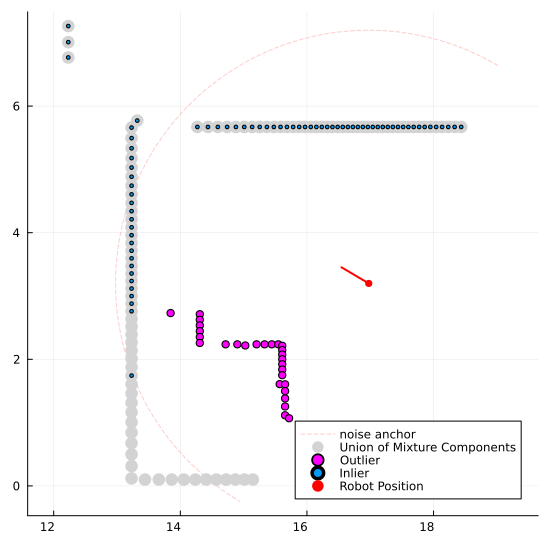

In [ ]:
t = 3

z1_ = CuArray(stack([_zs_appr[t]]))
z2_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 20
sig     = 0.1
outlier = 0.1
zmax    = 100.
scale_noise  = true
noise_anchor = 4.0

ỹ_, d̃_ = get_1d_mixture_components(z1_, as_, w;
                                   wrap=false, fill=false, fill_val_z=zmax, fill_val_a=0.0);


println(size(z2_), size(ỹ_), size(d̃_), size(_as))

log_p, ptw, outl = depthdist_logpdf(z2_, ỹ_, d̃_, sig, outlier, zmax, noise_anchor; 
                                    scale_noise=scale_noise, return_pointwise=true, return_outliermap=true);

log_p = Array(log_p)
ptw   = Array(ptw)
outl  = Array(outl);
cs = peak_to_peak(ptw[1,:])
na = polar_inv(fill(noise_anchor,length(_as)), _as)


println(size(log_p), size(ptw), size(outl))

# # ----------------
mypl = plot(size=(550,550), aspect_ratio=:equal)

plot!(na.*_ps[t], c=:red, alpha=0.2, linestyle=:dash, label="noise anchor")
scatter!(_ys_appr[t].*_ps[t], markerstrokewidth=0, c=:lightgray, markersize=7,     label="Union of Mixture Components")
scatter!(_ys[t][outl[1,:]].*_ps[t], markerstrokewidth=1, c=:magenta, markersize=4, label="Outlier")
scatter!(_ys[t][.!outl[1,:]].*_ps[t], markerstrokewidth=1, c=col[1], markersize=2, label="Inlier")
scatter!([_ps[t].x], c=:red, markerstrokewidth=0, label="Robot Position")
plot!(_ps[t], c=:red, linewidth=2, label=nothing)

In [ ]:
t = 3

z1_ = DeviceArray(stack([_zs_appr[t]]))
z2_ = DeviceArray(stack([_zs[t]]))
as_ = DeviceArray(_as);

w       = 10
sig     = range(0.1,0.01, 6)
outlier = range(0.1,0.01, 7)
zmax    = 100.

sig_     = DeviceArray(sig)
outlier_ = DeviceArray(outlier)

println("Sizes sig, outlier:")
println(size(sig))
println(size(outlier))

ỹ_, w̃_ = get_1d_mixture_components(z1_, as_, w;
                                    wrap=false, fill=false);

println("Sizes ỹ_, w̃_:")
println(size(ỹ_))
println(size(w̃_))

log_p, ptw, outl = depthdist_logpdf(z2_, ỹ_, w̃_, sig_, outlier_, zmax; 
                                    return_pointwise=true, return_outliermap=true);

println("Sizes log_p, ptw, outl:")
println(size(log_p))
println(size(ptw))
println(size(outl))

Sizes sig, outlier:
(6,)
(7,)
Sizes ỹ_, w̃_:
(1, 100, 21)
(1, 100, 21)
Sizes log_p, ptw, outl:
(1, 6, 7)
(1, 100, 6, 7)
(1, 100, 6, 7)


### Distribution

In [367]:
#nbx
using Distributions: TruncatedNormal

struct DepthDistribution2DP3 <: Distribution{Vector{Float64}}
end

"""
```julia
    z::Vector{Float64} = depthdist_2dp3(ỹ, d̃, sig, outlier, zmax, scale_noise=false, noise_anchor=1.0)
```
Restricted distribution from the 2dp3-likelihood. 
Takes 1d-mixture components `ỹ` and their weights ` d̃`,  and 
samples a vector `z` of depth values.

Arguments:
 - `ỹ`: 1d-mixture components `(n,m)`
 - `d̃`: 1d-mixture distances `(n,m)`
 - `sig`: Standard deviation of sensor noise
 - `outlier`: Outlier probability
 - `zmax`: Maximum depth value
 - `scale_noise`: Whether to scale each mixture components noise with its distance
 - `noise_anchor`: Distance at which sensor noise equals `sig`

Returns:
 - `z`: Observation vector of depth values `(n,)`


Example:
```julia
_fov   = π
_num_a = 100
_as    = range(-1_fov/2, _fov/2, _num_a);

# This should come from a renderer
z′ = 2 .+ cos.(range(0, 4π, _num_a))
z′ = reshape(z′, 1, :)

w = 10

args = ( 
    sig     = 0.1,
    outlier = 0.01,
    zmax    = 4.,
    scale_noise = true,
    noise_anchor = 2.0,
)

ỹ, d̃ = get_1d_mixture_components(z′, _as, w);
zs = [depthdist_2dp3(ỹ[1,:,:], d̃[1,:,:], args...) for i=1:100];

# -----------------------------------------------
mypl = plot(size=(800,300), ylim=(0,4.5))
scatter!(_as, z′[1,:], c=:lightgray, markerstrokewidth=0,  
         markersize=8, label="Mixture Comp. (from renderer)")
for (i,z) in enumerate(zs)
    label = i == 1 ? "Depth Samples" : nothing;
    scatter!(_as, z, c=col[1], markersize=1,  markerstrokewidth=0,  label=label)
end
display(mypl)
```

"""
const depthdist_2dp3 = DepthDistribution2DP3()


function Gen.logpdf(::DepthDistribution2DP3, z, ỹ, d̃, sig, outlier, zmax, scale_noise=false, noise_anchor=1.0)
    n = size(ỹ, 1)
    m = size(ỹ, 2)
    
    ỹ = reshape(ỹ, 1, n, m) 
    d̃ = reshape(d̃, 1, n, m) 
    
    log_p, = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax, noise_anchor; scale_noise=scale_noise, return_pointwise=false, return_outliermap=false)

    if _cuda[]
        log_p = CUDA.@allowscalar log_p[1]
    else
        log_p = log_p[1]
    end
    return log_p
end

function Gen.random(::DepthDistribution2DP3, ỹ, d̃, sig, outlier, zmax, scale_noise=false, noise_anchor=1.0)
    n = size(ỹ,1)
    m = size(ỹ,2)
    
    # Sample a depth values `z`
    z = Float64[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution using `zmax`.
            z_i = uniform(0.0, zmax)
        else
            # @assert sum(exp.(w̃[i,:])) == 1.0
            # Scale noise level proportional to depth of the mixture component.
            # Todo: Is this the right way to do it? Should we clamp `sig`?
            ỹ = Array(ỹ)
            d̃ = Array(d̃)

            if scale_noise
                # At distance `noise_anchor` the noise is `sig`    
                sig′ = ỹ[i,:]./noise_anchor .* sig
            end
        
            # Compute normalized mixture weights
            w̃ = gaussian_logpdf(d̃[i,:], 0.0, sig)
            w̃ = w̃ .- logsumexp(w̃)
            
            probs = exp.(w̃)/sum(exp.(w̃))
            j   = categorical(probs)
            z_i = rand(TruncatedNormal(ỹ[i,j], scale_noise ? sig′[j] : sig, 0.0, zmax))
        end
        push!(z, z_i)
    end
    
    return z
end

(D::DepthDistribution2DP3)(args...)          = Gen.random(D, args...)
Gen.has_output_grad(::DepthDistribution2DP3) = false
Gen.has_argument_grads(::DepthDistribution2DP3) = (false, false);


export depthdist_2dp3;

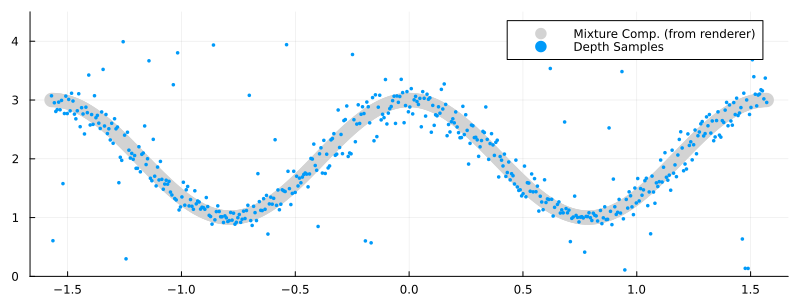

In [414]:
_fov   = π
_num_a = 500
_as    = range(-1_fov/2, _fov/2, _num_a);

# This should come from a renderer
z′ = 2 .+ cos.(range(0, 4π, _num_a))
z′ = reshape(z′, 1, :)

w = 10

args = ( 
    sig     = 0.2,
    outlier = 0.1,
    zmax    = 4.,
    scale_noise = true,
    noise_anchor = 3.0,
)

ỹ, d̃ = get_1d_mixture_components(z′, _as, w);
z = depthdist_2dp3(ỹ[1,:,:], d̃[1,:,:], args...);

# ---------------------------
plot(size=(800,300), ylim=(0,4.5))
scatter!(_as, z′[1,:], c=:lightgray, markerstrokewidth=0,  markersize=8, label="Mixture Comp. (from renderer)")
scatter!(_as, z, c=col[1], markersize=2,  markerstrokewidth=0, label="Depth Samples")

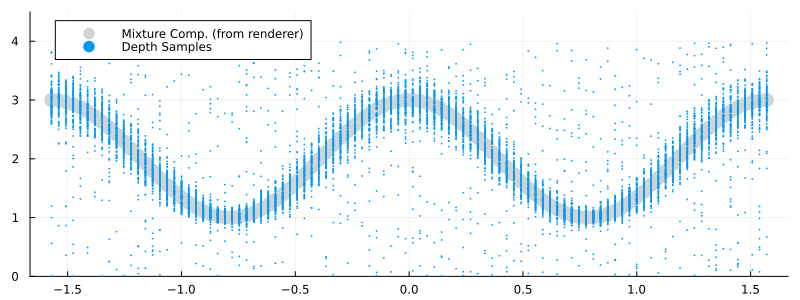

In [417]:
_fov   = π
_num_a = 100
_as    = range(-1_fov/2, _fov/2, _num_a);

# This should come from a renderer
z′ = 2 .+ cos.(range(0, 4π, _num_a))
z′ = reshape(z′, 1, :)

w = 2

args = ( 
    sig     = 0.2,
    outlier = 0.1,
    zmax    = 4.,
    scale_noise = true,
    noise_anchor = 3.0,
)

ỹ, d̃ = get_1d_mixture_components(z′, _as, w);
zs = [depthdist_2dp3(ỹ[1,:,:], d̃[1,:,:], args...) for i=1:100];

# ---------------------------
mypl = plot(size=(800,300), ylim=(0,4.5))
scatter!(_as, z′[1,:], c=:lightgray, markerstrokewidth=0,  markersize=8, label="Mixture Comp. (from renderer)")
for (i,z) in enumerate(zs)
    label = i == 1 ? "Depth Samples" : nothing;
    scatter!(_as, z, c=col[1], markersize=1,  markerstrokewidth=0,  label=label)
end
mypl

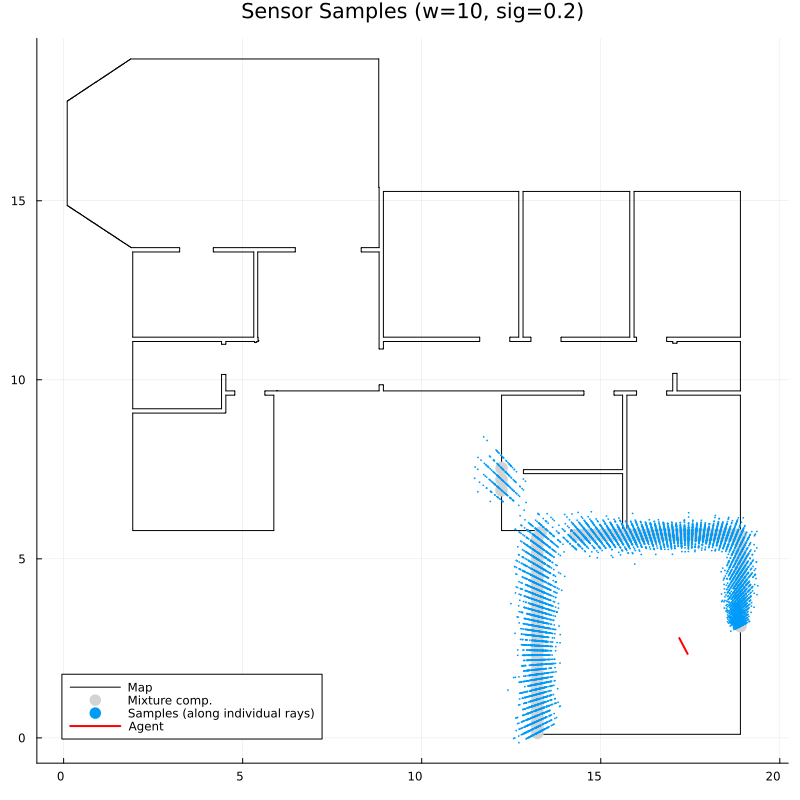

In [366]:
t = 2

z1_ = CuArray(stack([_zs_appr[t]]))
z2_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 10
sig     = 0.2
outlier = 0.0
zmax    = 10.
scale_noise = true
noise_anchor = 4.0

ỹ_, d̃_ = get_1d_mixture_components(z1_, as_, w);

ỹ_ = ỹ_[1,:,:]
d̃_ = d̃_[1,:,:]

zs = [depthdist_2dp3(ỹ_, d̃_, sig, outlier, zmax, scale_noise, noise_anchor) for s=1:100]
ys = polar_inv.(zs, [_as])

# ----------------------------------
mypl = plot(size=(800,800), aspect_ratio=:equal, title="Sensor Samples (w=$(w), sig=$(sig))")
plot!(_segs, c=:black, linewidth=1, label="Map")
scatter!(_ys_appr[t] .* _ps[t], markerstrokewidth=0, c=:lightgray, markersize=7,     label="Mixture comp.")
y = reduce(vcat, ys)
scatter!(y .* _ps[t], markerstrokewidth=0, c=col[1], markersize=1, alpha=1., label="Samples (along individual rays)")
plot!(_ps[t], r=0.5, c=:red, linewidth=2, label="Agent")
savefig(mypl, "_imgs/sensor_samples_w$(w)_sig$(sig).png")
mypl

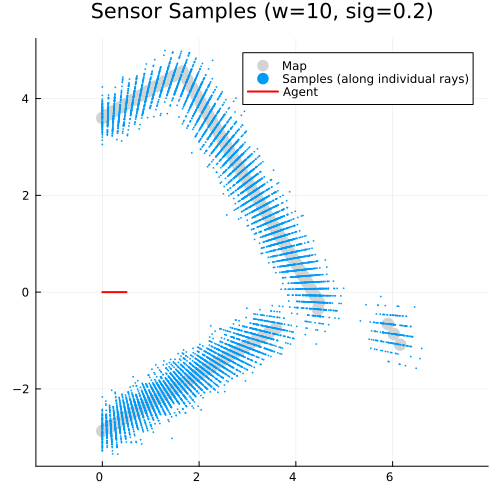

In [327]:
t = 3

z1_ = CuArray(stack([_zs_appr[t]]))
z2_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 10
sig     = 0.2
outlier = 0.0
zmax    = 10.

ỹ_, w̃_ = get_1d_mixture_components(z1_, as_, w);

ỹ_ = ỹ_[1,:,:]
w̃_ = w̃_[1,:,:]

zs = [depthdist_2dp3(ỹ_, w̃_, sig, outlier, zmax) for s=1:100]
ys = polar_inv.(zs, [_as])

# ----------------------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Sensor Samples (w=$(w), sig=$(sig))")
scatter!(_ys_appr[t], markerstrokewidth=0, c=:lightgray, markersize=7,     label="Map")
y = reduce(vcat, ys)
scatter!(y, markerstrokewidth=0, c=col[1], markersize=1, alpha=1., label="Samples (along individual rays)")
plot!(Pose(), r=0.5, c=:red, linewidth=2, label="Agent")
savefig(mypl, "_imgs/sensor_samples_w$(w)_sig$(sig).png")
mypl